##  The Ultimate Data Challenge
Group: XLD 
Member :
Tong Liu,
Runtao Xue,
Jiexuan Du,
Zhikai Mao 
# Lennox stores Will Call Market Success Analysis
## Targets:
1. What are the best predictors of successfully meeting store sales goals?
2. How much do each of the factors contribute to the overall model?
3. What would be the predicted sales for each plant the end of 2015?
4. What are some key KPIs that can be used to assess the performance of a plant?
5. Develop a UI for store employees to view previous and predicted results

In [1]:
# Show all outputs(default setting of Jupyter is only show last output).
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import packages

!pip install xlrd

import xlrd
import numpy as np
import pandas as pd
from functools import reduce

#### In this Data Science club challenge it’s based on the sales history of Lennox International. Goal is to find out what drives Will Call orders and predict Will call sales for the future. 

## Import Data

In [4]:
# Import data

prefix = 'Final Data/'

# Billing Data
train_df = pd.read_csv(prefix + 'Billing_Data_Train_vf.csv')
val_df = pd.read_csv(prefix + 'Billing_Data_Validation_vf.csv')
test_df = pd.read_csv(prefix + 'Billing_Data_Test_vf.csv')

# Customer Data
cus_df = pd.read_csv(prefix + 'Customer_vf.csv')

# Demographic Data
zlw_df = pd.read_csv(prefix + 'ZIP_LND_WTR.csv')
zd_df = pd.read_csv(prefix + 'zips_demos.csv', encoding = 'ISO-8859-1')

# Store Data
sm_2014_df = pd.read_excel(prefix + 'Store Metrics.xlsx', 'Metrics_2014')
sm_2015_df = pd.read_excel(prefix + 'Store Metrics.xlsx', 'Metrics_2015')
sc_df = pd.read_csv(prefix + 'Store_charateristics_vf.csv')
sft_df = pd.read_csv(prefix + 'Store_footTraffic.csv')

In [5]:
categorical_columns = ['Plant', 
                       'Sold_To_Party', 
                       'FISCAL_YEAR_PERIOD', 
                       'Category', 
                       'Fiscal_Year'
                      ]
dfs = [train_df, val_df, test_df]

for df in dfs:
    df[categorical_columns].fillna('unkown', inplace = True)
    df.fillna(value=0, inplace = True)

categoricals = categorical_columns
indexes_of_categorical_columns = [train_df.columns.get_loc(col) for col in categoricals]

#### First foremost is the data cleaning part, in this process we noticed there are 2013, 2014, 2015 three years’ sales data but in store metrics there’s no year 2013 records, so we decided to drop the 2013 data in the training set to match the store metrics data for later analysis. 

### Drop Data of train data in year of 2013

In [6]:
print('Fiscal_Year in train data: ', train_df['Fiscal_Year'].unique())
print('Fiscal_Year in validation data: ', val_df['Fiscal_Year'].unique())
print('Fiscal_Year in test data: ', test_df['Fiscal_Year'].unique())

Fiscal_Year in train data:  [2013 2014]
Fiscal_Year in validation data:  [2015]
Fiscal_Year in test data:  [2015]


In [7]:
train_df = train_df[train_df['Fiscal_Year'] == 2014]

#### After that we noticed the data in store metrics is 9 different kinds of data separated by month, means every kind of data has 12 columns from JAN to DEC total 108 columns, to match the training dataset we decide to modify it reshape it into 9 columns (for their distinguish), and row name by FISCAL_YEAR_PERIOD so it can be merged in to training dataset for further analysis. 

## Modify Store Metrics

In [8]:
# Modify Store Metrics

def modify_SM(df, num):
    new_col_p = []
    for i in range(len(df)-1):
        new_col_p += [df['Plant'][i] for j in range(12)]
    new_col_num = []
    for i in range(len(df)-1):
        new_col_num += range(num,num+12)
    
    dfs = pd.DataFrame({'Plant':new_col_p, 'FISCAL_YEAR_PERIOD':new_col_num})
    
    tmp = df.iloc[:, 1:].transpose().reset_index()
    
    names = ['WC MTD % to Quota', 
             'SMA MTD % to Quota', 
             'Store Account MTD % to Quota', 
             'Parts & Supplies MTD % to Quota', 
             'Avg Tkt Rev', 
             'Avg Tkt YoY Growth', 
             'Phone Calls', 
             'Mktg Adopt', 
             'VOC'
            ]
    
    for i, name in enumerate(names):
        new_col_c = []
        for j in range(len(df)-1):
            new_col_c += list(tmp[j][i*12:(i+1)*12])
        for index, item in enumerate(new_col_c):
            if not np.isreal(item):
                new_col_c[index] = 0
        dfs[name] = new_col_c

    return dfs

sm_wc_2014 = modify_SM(sm_2014_df, 2014001) 
sm_wc_2015 = modify_SM(sm_2015_df, 2015001) 

#### Then we observed the Customer Data for the merging purpose, compared to the training dataset we need to change the Cust_Zip into Zip Key, and also Customer No in to Sold_To_Party. In store metrics the Store Zip is also changed in to Zip key, now we have a link between training dataset and these two datasets. And we can merge now.

## Merge Data

In [9]:
# Merge Data

train_df_new = pd.merge(train_df, sm_wc_2014)
val_df_new = pd.merge(val_df, sm_wc_2015)
test_df_new = pd.merge(test_df, sm_wc_2015, how='left')

# Customer Data
cd = cus_df
cd = cd.rename(columns={'Cust_Zip':'Zip Key', 'Customer No.':'Sold_To_Party'})

# Demographic Data
dd = pd.merge(zlw_df, zd_df)
#dd = zlw_df

# Store Data
sc_df = sc_df.rename(columns={'Store Zip':'Zip Key'})
dfs = pd.merge(sc_df, sft_df)

# Final Merge
dfs_t = [train_df_new, cd, dd, dfs]
train_df_new = reduce(lambda left,right: pd.merge(left,right), dfs_t)
dfs_v = [val_df_new, cd, dd, dfs]
val_df_new = reduce(lambda left,right: pd.merge(left,right), dfs_v)
#dfs_tt = [test_df_new, cd, dd, dfs]
dfs_tt = [dfs, dd, cd, test_df_new]
test_df_new = reduce(lambda left,right: pd.merge(left,right, how='right'), dfs_tt)

In [10]:
pd.options.display.max_columns=None
display(train_df_new.head())
train_df_new.shape

,Plant,Sold_To_Party,FISCAL_YEAR_PERIOD,Category,Fiscal_Year,Sales,WC MTD % to Quota,SMA MTD % to Quota,Store Account MTD % to Quota,Parts & Supplies MTD % to Quota,Avg Tkt Rev,Avg Tkt YoY Growth,Phone Calls,Mktg Adopt,VOC,Cluster,Premier_Dealer__c,Marketing Package,Zip Key,LANDSQMI,WATERSQMI,POPULATION,HSGUNITS,"Basic Variables Current Year Estimates A (2015) Age Total (Pop) Average (Mean) Age, Total","Basic Variables Current Year Estimates A (2015) Age Total (Pop) Median Age, Total",Basic Variables Current Year Estimates A (2015) Age Total (Pop) Total Population,Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total 7th and 8th grade,Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total Associate's degree,Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total Bachelor's degree,Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total Doctorate degree,"Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total High school graduate, GED, or alternative",Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total Master's degree,Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total No schooling completed,Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total Nursery to 4th grade,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) 1-Person Households,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) 2-Person Households,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) 3-Person Households,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) 4-Person Households,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) 5-Person Households,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) 6-Person Households,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) 7+ Person Households,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) Total Households,Basic Variables Current Year Estimates A (2015) Income Household Average (Mean) Household Income,"Basic Variables Current Year Estimates A (2015) Income Household Household Income < $10,000","Basic Variables Current Year Estimates A (2015) Income Household Household Income $10,000-$14,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $15,000-$19,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $20,000-$24,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $25,000-$29,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $30,000-$34,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $35,000-$39,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $40,000-$44,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $45,000-$49,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $50,000-$59,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $60,000-$74,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $75,000-$99,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $100,000-$124,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $125,000-$149,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $150,000-$199,999","B

(18425, 112)

#### After the merge of customer, demographic, store metrics and training dataset. We got a final data shaped (18425, 112), and most missing values are treated during this process, and some left over missing value in numeric value column is replaced by 0 after this step, and Null by categorical columns. Start from here we did more data exploration and cleaning.

## Missing values 

In [11]:
# Counting missing values.
dfs = {'train_df_new': train_df_new, 
       'val_df_new': val_df_new, 
       'test_df_new': test_df_new, 
      }
for i in dfs:
    if dfs[i].isnull().values.any():
        print(i + '\n')
        print(dfs[i].isnull().sum()[dfs[i].isnull().sum().T != 0])
        print('\n')

train_df_new

VOC    20
dtype: int64


test_df_new

Trade Area Size                                                                                                                                          139715
Store Size                                                                                                                                               139715
Store Type                                                                                                                                               139717
Opening Date                                                                                                                                             139715
Does Store Have a Fleet Delivery Truck?                                                                                                                  139715
Zip Key                                                                                                                                             

#### There are 13 columns of categorical value noticed in the merged dataset, one thing in the Trade Area Size the “small Market” is replaced by “Small Market”, one capital letter difference can do a lot of trouble even after encoding. After the treatment we encoded all the categorical data and the dataset is filled with numeric data and ready for some analysis. 



### Filter categorical columns

In [12]:
categorical_columns = ['Plant', 
                       'Sold_To_Party', 
                       'FISCAL_YEAR_PERIOD', 
                       'Category', 
                       'Cluster', 
                       'Premier_Dealer__c', 
                       'Marketing Package', 
                       'Zip Key', 
                       'Trade Area Size ', 
                       'Store Size', 
                       'Store Type', 
                       'Opening Date', 
                       'Does Store Have a Fleet Delivery Truck?'
                      ]

In [13]:
categoricals = categorical_columns
indexes_of_categorical_columns = [train_df_new.columns.get_loc(col) for col in categoricals]

In [14]:
dfs = [train_df_new, val_df_new, test_df_new]

for df in dfs:
    df[categorical_columns].fillna('unkown', inplace = True)
    df.fillna(value=0, inplace = True)

In [15]:
train_df_new[categorical_columns].nunique()

Plant                                       176
Sold_To_Party                              1575
FISCAL_YEAR_PERIOD                           12
Category                                     15
Cluster                                       3
Premier_Dealer__c                             2
Marketing Package                             4
Zip Key                                     175
Trade Area Size                               4
Store Size                                    3
Store Type                                    3
Opening Date                                156
Does Store Have a Fleet Delivery Truck?       2
dtype: int64

## Label Encoding

In [16]:
train_df_new['Trade Area Size '].replace({'small Market':'Small Market'}, inplace = True)

In [17]:
# Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#for df in [train_df_new, val_df_new, test_df_new]:
for df in dfs:
    for cat in categorical_columns:
        df[[cat]] = le.fit_transform(df[[cat]].astype(str))

In [18]:
train_df_new.head()

,Plant,Sold_To_Party,FISCAL_YEAR_PERIOD,Category,Fiscal_Year,Sales,WC MTD % to Quota,SMA MTD % to Quota,Store Account MTD % to Quota,Parts & Supplies MTD % to Quota,Avg Tkt Rev,Avg Tkt YoY Growth,Phone Calls,Mktg Adopt,VOC,Cluster,Premier_Dealer__c,Marketing Package,Zip Key,LANDSQMI,WATERSQMI,POPULATION,HSGUNITS,"Basic Variables Current Year Estimates A (2015) Age Total (Pop) Average (Mean) Age, Total","Basic Variables Current Year Estimates A (2015) Age Total (Pop) Median Age, Total",Basic Variables Current Year Estimates A (2015) Age Total (Pop) Total Population,Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total 7th and 8th grade,Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total Associate's degree,Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total Bachelor's degree,Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total Doctorate degree,"Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total High school graduate, GED, or alternative",Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total Master's degree,Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total No schooling completed,Basic Variables Current Year Estimates A (2015) Educational Attainment By Sex (Pop 25+) Total Nursery to 4th grade,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) 1-Person Households,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) 2-Person Households,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) 3-Person Households,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) 4-Person Households,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) 5-Person Households,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) 6-Person Households,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) 7+ Person Households,Basic Variables Current Year Estimates A (2015) Household Size By Household Type Total (HHs) Total Households,Basic Variables Current Year Estimates A (2015) Income Household Average (Mean) Household Income,"Basic Variables Current Year Estimates A (2015) Income Household Household Income < $10,000","Basic Variables Current Year Estimates A (2015) Income Household Household Income $10,000-$14,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $15,000-$19,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $20,000-$24,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $25,000-$29,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $30,000-$34,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $35,000-$39,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $40,000-$44,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $45,000-$49,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $50,000-$59,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $60,000-$74,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $75,000-$99,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $100,000-$124,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $125,000-$149,999","Basic Variables Current Year Estimates A (2015) Income Household Household Income $150,000-$199,999","B

## LightGBM model

In [19]:
!pip install lightgbm
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

    100% |################################| 1.2MB 18.0MB/s ta 0:00:01


In [20]:
X_train = train_df_new.drop(columns = ['Fiscal_Year'] + ['Sales'])
X_val = val_df_new.drop(columns = ['Fiscal_Year'] + ['Sales'])
y_train = train_df_new['Sales']
y_val = val_df_new['Sales']

In [21]:
#estimator = lgb.LGBMRegressor()
#
#param_grid = {
#    'objective': ['regression'], 
#    'boosting_type': ['gbdt'], 
#    'num_leaves': [5, 15, 25], 
#    'learning_rate': [0.1, 0.2, 0.4], 
#    'feature_fraction': [0.6, 0.7, 0.8], 
#    'bagging_fraction': [0.6, 0.7, 0.8], 
#    'bagging_freq': [5, 15, 25], 
#    'n_estimators': [20, 30, 40], 
#    'verbose': [0]
#}

#gbm = GridSearchCV(estimator, param_grid, cv = 5, n_jobs = 1)
#gbm.fit(X_train, y_train)

#print('Best parameters found by grid search are:', gbm.best_params_)

In [22]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, label = y_train)
lgb_eval = lgb.Dataset(X_val, label = y_val)

gbm = lgb.LGBMRegressor(boosting_type = 'gbdt',
                        num_leaves = 25, 
                        learning_rate = 0.1, 
                        feature_fraction = 0.6, 
                        bagging_fraction = 0.8, 
                        bagging_freq = 25, 
                        n_estimators = 20, 
                        verbose = 0
                       )

print('Starting training...')
# train

gbm.fit(X_train, y_train,
        eval_set = [(X_val, y_val)],
        eval_metric = 'l1',
        early_stopping_rounds = 5, 
        categorical_feature = indexes_of_categorical_columns)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration_)
# eval
print('The rmse of prediction is:', mean_squared_error(y_val, y_pred) ** 0.5)

Starting training...
[1]	valid_0's l1: 90.0435	valid_0's l2: 52711
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 86.4846	valid_0's l2: 51662.6
[3]	valid_0's l1: 83.5214	valid_0's l2: 50814.5
[4]	valid_0's l1: 80.5935	valid_0's l2: 50013
[5]	valid_0's l1: 78.1558	valid_0's l2: 49439.1
[6]	valid_0's l1: 75.5664	valid_0's l2: 47249.4
[7]	valid_0's l1: 74.24	valid_0's l2: 46574.1
[8]	valid_0's l1: 72.7061	valid_0's l2: 46686.4
[9]	valid_0's l1: 71.388	valid_0's l2: 46802.5
[10]	valid_0's l1: 69.7329	valid_0's l2: 46416.6
[11]	valid_0's l1: 68.4339	valid_0's l2: 46313.4
[12]	valid_0's l1: 66.979	valid_0's l2: 45549.9
[13]	valid_0's l1: 65.8765	valid_0's l2: 45082.7
[14]	valid_0's l1: 65.1942	valid_0's l2: 45197.3
[15]	valid_0's l1: 64.1194	valid_0's l2: 44351.3
[16]	valid_0's l1: 63.2672	valid_0's l2: 43484.2
[17]	valid_0's l1: 62.8833	valid_0's l2: 43558.1
[18]	valid_0's l1: 62.0884	valid_0's l2: 42870.4
[19]	valid_0's l1: 62.1861	valid_0's l2: 42824.9
[20]

LGBMRegressor(bagging_fraction=0.8, bagging_freq=25, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=20, n_jobs=-1, num_leaves=25, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=0)

Starting predicting...
The rmse of prediction is: 205.6580802291214


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'LightGBM Features (avg over folds)')

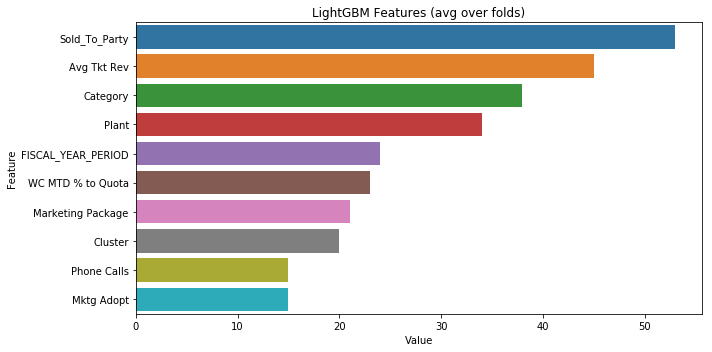

In [24]:
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data = feature_imp.sort_values(by="Value", ascending=False).iloc[:10])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## Prediction

In [26]:
X_test = test_df_new.drop(columns = ['Fiscal_Year'] + ['Sales']).values
preds = gbm.predict(X_test)

In [27]:
subm = test_df
subm['Sales'] = preds
subm.to_csv('submission_lgbm.csv', index=False)

In [28]:
subm_plant = subm.drop(columns = ['Fiscal_Year'] + ['FISCAL_YEAR_PERIOD'] + ['Sold_To_Party']).groupby(['Plant']).sum()
subm_plant.to_csv('Sails_of_Plant_2015.csv', index=True)

In [29]:
subm['Sales'].describe()

count    149731.000000
mean         19.711178
std          17.579222
min          10.482566
25%          16.787647
50%          16.787647
75%          16.787647
max         198.507229
Name: Sales, dtype: float64